In [58]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow import keras
from keras.models import model_from_json
import numpy as np
import pandas as pd
import time
import tensorflow as tf

In [59]:
# datos: secuencia de observaciones como una lista o matriz 2D NumPy. Necesario.
# n_in: Número de observaciones de retraso como entrada (X). Los valores pueden estar entre [1..len (datos)] Opcional. El valor predeterminado es 1.
# n_out: Número de observaciones como salida (y). Los valores pueden estar entre [0..len (datos) -1]. Opcional. Por defecto es 1.
# dropnan: booleano si se deben soltar o no filas con valores NaN. Opcional. Por defecto es verdadero.


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
# observaciones pasadas  (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# tiempos futuros  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [60]:
data = pd.read_excel('../PreparacionDatos/FloraTotal_3mes_pib.xlsx' , sheet_name='FloraTotal' ,header=0)

In [61]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'PM10', 'Motos_vehiculos_particulares',
       'Lluvia', 'Poblacion', 'PIB'],
      dtype='object')

In [62]:
#Borro solo columnas sin datos

data = data.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)


In [63]:
data.columns

Index(['PM10', 'Motos_vehiculos_particulares', 'Lluvia', 'Poblacion', 'PIB'], dtype='object')

In [64]:
series_to_supervised(data, 1, 1)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,24.953753,348066.0,0.939613,2244668.0,12368151.0,19.868654,348066,0.382813,2244668,12368151
2,19.868654,348066.0,0.382813,2244668.0,12368151.0,27.656900,348066,0.263172,2244668,12368151
3,27.656900,348066.0,0.263172,2244668.0,12368151.0,26.076992,348066,0.572834,2244668,12368151
4,26.076992,348066.0,0.572834,2244668.0,12368151.0,27.081070,391327,0.190382,2269653,13201435
5,27.081070,391327.0,0.190382,2269653.0,13201435.0,24.417490,391327,0.413592,2269653,13201435
6,24.417490,391327.0,0.413592,2269653.0,13201435.0,33.543011,391327,0.408934,2269653,13201435
7,33.543011,391327.0,0.408934,2269653.0,13201435.0,26.189116,391327,0.595508,2269653,13201435
8,26.189116,391327.0,0.595508,2269653.0,13201435.0,28.528126,438769,0.060729,2294653,13978550
9,28.528126,438769.0,0.060729,2294653.0,13978550.0,16.134058,438769,0.426957,2294653,13978550
10,16.134058,438769.0,0.426957,2294653.0,13978550.0,28.120001,438769,0.107707,2294653,13978550


In [65]:


data.describe()

,PM10,Motos_vehiculos_particulares,Lluvia,Poblacion,PIB
count,32.000000,32.000000,32.000000,3.200000e+01,3.200000e+01
mean,29.407487,498530.625000,0.282681,2.332282e+06,1.554767e+07
std,8.065527,96047.452489,0.186494,5.833838e+04,2.283018e+06
min,16.134058,348066.000000,0.015700,2.244668e+06,1.236815e+07
25%,24.819687,426908.500000,0.173525,2.288403e+06,1.378427e+07
50%,28.018413,505229.000000,0.244030,2.332209e+06,1.529301e+07
75%,33.663911,575963.250000,0.389344,2.376097e+06,1.725658e+07
max,47.904537,630478.000000,0.939613,2.420114e+06,1.906559e+07


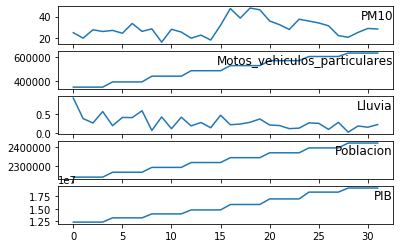

<Figure size 1728x432 with 0 Axes>

In [66]:
# Reprecentacion de los datos.
from matplotlib import pyplot
groups = [0,1,2,3,4]
i = 1
values = data.values
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(data.columns[group], y=0.5, loc='right')
    i += 1
pyplot.figure(figsize=(24,6))
pyplot.show()

In [67]:
data

,PM10,Motos_vehiculos_particulares,Lluvia,Poblacion,PIB
0,24.953753,348066,0.939613,2244668,12368151
1,19.868654,348066,0.382813,2244668,12368151
2,27.656900,348066,0.263172,2244668,12368151
3,26.076992,348066,0.572834,2244668,12368151
4,27.081070,391327,0.190382,2269653,13201435
5,24.417490,391327,0.413592,2269653,13201435
6,33.543011,391327,0.408934,2269653,13201435
7,26.189116,391327,0.595508,2269653,13201435
8,28.528126,438769,0.060729,2294653,13978550
9,16.134058,438769,0.426957,2294653,13978550


In [68]:
data.columns

Index(['PM10', 'Motos_vehiculos_particulares', 'Lluvia', 'Poblacion', 'PIB'], dtype='object')

In [69]:
values = data.values
values = values.astype('float32')


In [70]:


#Normalize features(0,1)
#Este estimador escala y traduce cada característica
#individualmente de modo que esté en el rango dado en el conjunto de entrenamiento
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [71]:
scaled

array([[0.27760655, 0.        , 1.        , 0.        , 0.        ],
       [0.11754924, 0.        , 0.3973462 , 0.        , 0.        ],
       [0.3626902 , 0.        , 0.2678517 , 0.        , 0.        ],
       [0.3129614 , 0.        , 0.6030158 , 0.        , 0.        ],
       [0.3445655 , 0.15318406, 0.1890668 , 0.14240837, 0.12441826],
       [0.2607273 , 0.15318406, 0.43065938, 0.14240837, 0.12441826],
       [0.54796   , 0.15318406, 0.42561764, 0.14240837, 0.12441826],
       [0.3164906 , 0.15318406, 0.627557  , 0.14240837, 0.12441826],
       [0.3901127 , 0.3211727 , 0.04873698, 0.28490257, 0.24045002],
       [0.        , 0.3211727 , 0.44512463, 0.28490257, 0.24045002],
       [0.37726665, 0.3211727 , 0.09958397, 0.28490257, 0.24045002],
       [0.29540235, 0.3211727 , 0.43738487, 0.28490257, 0.24045002],
       [0.11658496, 0.4817537 , 0.18335706, 0.4275732 , 0.35701787],
       [0.2060349 , 0.4817537 , 0.2818562 , 0.4275732 , 0.35701787],
       [0.06128895, 0.4817537 , 0.

In [72]:

reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head())


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)   var2(t)  \
1   0.277607   0.000000   1.000000   0.000000   0.000000  0.117549  0.000000   
2   0.117549   0.000000   0.397346   0.000000   0.000000  0.362690  0.000000   
3   0.362690   0.000000   0.267852   0.000000   0.000000  0.312961  0.000000   
4   0.312961   0.000000   0.603016   0.000000   0.000000  0.344566  0.153184   
5   0.344566   0.153184   0.189067   0.142408   0.124418  0.260727  0.153184   

    var3(t)   var4(t)   var5(t)  
1  0.397346  0.000000  0.000000  
2  0.267852  0.000000  0.000000  
3  0.603016  0.000000  0.000000  
4  0.189067  0.142408  0.124418  
5  0.430659  0.142408  0.124418  


In [73]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'],
      dtype='object')

In [74]:
#Dejo la variable objetico en PM10 (T) y y todas (T-1)...................
reframed.drop(reframed.columns[[0,6,7,8,9]], axis=1, inplace=True)
print(reframed.head())

   var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.000000   1.000000   0.000000   0.000000  0.117549
2   0.000000   0.397346   0.000000   0.000000  0.362690
3   0.000000   0.267852   0.000000   0.000000  0.312961
4   0.000000   0.603016   0.000000   0.000000  0.344566
5   0.153184   0.189067   0.142408   0.124418  0.260727


In [75]:
reframed.columns

Index(['var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var1(t)'], dtype='object')

In [76]:
values = reframed.values

In [77]:
values = reframed.values

#Datos de entrenamiento y pruebas:
n_train_hours = 23
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


In [78]:
test

array([[0.7764791 , 0.1174261 , 0.7133417 , 0.67998755, 0.6181448 ],
       [0.89843214, 0.27022076, 0.85642815, 0.8796166 , 0.5631817 ],
       [0.89843214, 0.25771138, 0.85642815, 0.8796166 , 0.47911185],
       [0.89843214, 0.07924192, 0.85642815, 0.8796166 , 0.19131386],
       [0.89843214, 0.28694546, 0.85642815, 0.8796166 , 0.14310068],
       [1.0000001 , 0.        , 1.        , 0.9999999 , 0.28508067],
       [1.0000001 , 0.17980051, 1.        , 0.9999999 , 0.40200222],
       [1.0000001 , 0.14388649, 1.        , 0.9999999 , 0.38437665]],
      dtype=float32)

In [79]:
train

array([[0.        , 1.        , 0.        , 0.        , 0.11754924],
       [0.        , 0.3973462 , 0.        , 0.        , 0.3626902 ],
       [0.        , 0.2678517 , 0.        , 0.        , 0.3129614 ],
       [0.        , 0.6030158 , 0.        , 0.        , 0.3445655 ],
       [0.15318406, 0.1890668 , 0.14240837, 0.12441826, 0.2607273 ],
       [0.15318406, 0.43065938, 0.14240837, 0.12441826, 0.54796   ],
       [0.15318406, 0.42561764, 0.14240837, 0.12441826, 0.3164906 ],
       [0.15318406, 0.627557  , 0.14240837, 0.12441826, 0.3901127 ],
       [0.3211727 , 0.04873698, 0.28490257, 0.24045002, 0.        ],
       [0.3211727 , 0.44512463, 0.28490257, 0.24045002, 0.37726665],
       [0.3211727 , 0.09958397, 0.28490257, 0.24045002, 0.29540235],
       [0.3211727 , 0.43738487, 0.28490257, 0.24045002, 0.11658496],
       [0.4817537 , 0.18335706, 0.4275732 , 0.35701787, 0.2060349 ],
       [0.4817537 , 0.2818562 , 0.4275732 , 0.35701787, 0.06128895],
       [0.4817537 , 0.12822917, 0.

In [80]:
train[:, :-1]

array([[0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.3973462 , 0.        , 0.        ],
       [0.        , 0.2678517 , 0.        , 0.        ],
       [0.        , 0.6030158 , 0.        , 0.        ],
       [0.15318406, 0.1890668 , 0.14240837, 0.12441826],
       [0.15318406, 0.43065938, 0.14240837, 0.12441826],
       [0.15318406, 0.42561764, 0.14240837, 0.12441826],
       [0.15318406, 0.627557  , 0.14240837, 0.12441826],
       [0.3211727 , 0.04873698, 0.28490257, 0.24045002],
       [0.3211727 , 0.44512463, 0.28490257, 0.24045002],
       [0.3211727 , 0.09958397, 0.28490257, 0.24045002],
       [0.3211727 , 0.43738487, 0.28490257, 0.24045002],
       [0.4817537 , 0.18335706, 0.4275732 , 0.35701787],
       [0.4817537 , 0.2818562 , 0.4275732 , 0.35701787],
       [0.4817537 , 0.12822917, 0.4275732 , 0.35701787],
       [0.4817537 , 0.49481776, 0.4275732 , 0.35701787],
       [0.6312516 , 0.2164133 , 0.5703516 , 0.5164069 ],
       [0.6312516 , 0.23655559,

In [81]:
train[:, -1]

array([0.11754924, 0.3626902 , 0.3129614 , 0.3445655 , 0.2607273 ,
       0.54796   , 0.3164906 , 0.3901127 , 0.        , 0.37726665,
       0.29540235, 0.11658496, 0.2060349 , 0.06128895, 0.49686676,
       0.9867194 , 0.70497006, 0.99999994, 0.94905263, 0.6214743 ,
       0.5126626 , 0.37087148, 0.6731488 ], dtype=float32)

In [82]:
train[:, 0:]

array([[0.        , 1.        , 0.        , 0.        , 0.11754924],
       [0.        , 0.3973462 , 0.        , 0.        , 0.3626902 ],
       [0.        , 0.2678517 , 0.        , 0.        , 0.3129614 ],
       [0.        , 0.6030158 , 0.        , 0.        , 0.3445655 ],
       [0.15318406, 0.1890668 , 0.14240837, 0.12441826, 0.2607273 ],
       [0.15318406, 0.43065938, 0.14240837, 0.12441826, 0.54796   ],
       [0.15318406, 0.42561764, 0.14240837, 0.12441826, 0.3164906 ],
       [0.15318406, 0.627557  , 0.14240837, 0.12441826, 0.3901127 ],
       [0.3211727 , 0.04873698, 0.28490257, 0.24045002, 0.        ],
       [0.3211727 , 0.44512463, 0.28490257, 0.24045002, 0.37726665],
       [0.3211727 , 0.09958397, 0.28490257, 0.24045002, 0.29540235],
       [0.3211727 , 0.43738487, 0.28490257, 0.24045002, 0.11658496],
       [0.4817537 , 0.18335706, 0.4275732 , 0.35701787, 0.2060349 ],
       [0.4817537 , 0.2818562 , 0.4275732 , 0.35701787, 0.06128895],
       [0.4817537 , 0.12822917, 0.

In [83]:
# Datos de entrada y de salida.
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


#Remodelar la entrada para que sea 3D [muestras, pasos de tiempo, características]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(23, 1, 4) (23,) (8, 1, 4) (8,)


In [84]:
#Diseñando la red neuronal.
model = Sequential()

#Capa de entrada (unidades, 1, 3)
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))

#Capa de salida.
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.name="LTSM_cali_3meses_pib"

#fit(x=None, y=None, batch_size=None, epochs=1, 
#verbose=1, callbacks=None, validation_split=0.0, validation_data=None, 
#shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
#validation_steps=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                11000     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


Train on 23 samples, validate on 8 samples
Epoch 1/50
 - 1s - loss: 0.4373 - val_loss: 0.4003
Epoch 2/50
 - 0s - loss: 0.4305 - val_loss: 0.3892
Epoch 3/50
 - 0s - loss: 0.4238 - val_loss: 0.3782
Epoch 4/50
 - 0s - loss: 0.4175 - val_loss: 0.3673
Epoch 5/50
 - 0s - loss: 0.4112 - val_loss: 0.3563
Epoch 6/50
 - 0s - loss: 0.4049 - val_loss: 0.3454
Epoch 7/50
 - 0s - loss: 0.3986 - val_loss: 0.3344
Epoch 8/50
 - 0s - loss: 0.3923 - val_loss: 0.3235
Epoch 9/50
 - 0s - loss: 0.3860 - val_loss: 0.3125
Epoch 10/50
 - 0s - loss: 0.3796 - val_loss: 0.3015
Epoch 11/50
 - 0s - loss: 0.3737 - val_loss: 0.2906
Epoch 12/50
 - 0s - loss: 0.3680 - val_loss: 0.2796
Epoch 13/50
 - 0s - loss: 0.3623 - val_loss: 0.2687
Epoch 14/50
 - 0s - loss: 0.3566 - val_loss: 0.2578
Epoch 15/50
 - 0s - loss: 0.3509 - val_loss: 0.2470
Epoch 16/50
 - 0s - loss: 0.3457 - val_loss: 0.2389
Epoch 17/50
 - 0s - loss: 0.3405 - val_loss: 0.2306
Epoch 18/50
 - 0s - loss: 0.3354 - val_loss: 0.2225
Epoch 19/50
 - 0s - loss: 0.33

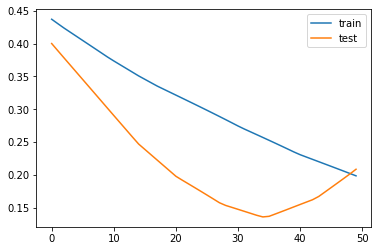

In [85]:

# Ajustado el modelo
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Seguimiento al modelo 
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [86]:
yhat = model.predict(test_X)
yhat.shape

(8, 1)

In [87]:
# Datos de prediccion.
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_X.shape

(8, 4)

In [88]:
inv_yhat = concatenate((yhat, test_X[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat

array([[3.1102621e+01, 5.6735300e+05, 1.2419187e-01, 2.3698210e+06,
        1.6922326e+07],
       [3.4063099e+01, 6.0179400e+05, 2.6536071e-01, 2.3949250e+06,
        1.8259330e+07],
       [3.3987064e+01, 6.0179400e+05, 2.5380316e-01, 2.3949250e+06,
        1.8259330e+07],
       [3.2899044e+01, 6.0179400e+05, 8.8913046e-02, 2.3949250e+06,
        1.8259330e+07],
       [3.4164707e+01, 6.0179400e+05, 2.8081286e-01, 2.3949250e+06,
        1.8259330e+07],
       [3.3988125e+01, 6.3047800e+05, 1.5700484e-02, 2.4201140e+06,
        1.9065590e+07],
       [3.5089966e+01, 6.3047800e+05, 1.8182035e-01, 2.4201140e+06,
        1.9065590e+07],
       [3.4870384e+01, 6.3047800e+05, 1.4863895e-01, 2.4201140e+06,
        1.9065590e+07]], dtype=float32)

In [89]:
inv_yhat = inv_yhat[:,0]

In [90]:
inv_yhat

array([31.102621, 34.0631  , 33.987064, 32.899044, 34.164707, 33.988125,
       35.089966, 34.870384], dtype=float32)

In [91]:
# invierco el scalar de la prediccion
inv_yhat = concatenate((yhat, test_X[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]


In [92]:
inv_yhat

array([31.102621, 34.0631  , 33.987064, 32.899044, 34.164707, 33.988125,
       35.089966, 34.870384], dtype=float32)

In [52]:

#Invierco el scalar de los dato reales
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, :]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calcular RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6.894


In [93]:
#Datos reales
inv_y

array([35.772816, 34.02661 , 31.35567 , 22.212193, 20.680435, 25.191208,
       28.90586 , 28.345888], dtype=float32)

In [94]:
#Datos prediccion
inv_yhat

array([31.102621, 34.0631  , 33.987064, 32.899044, 34.164707, 33.988125,
       35.089966, 34.870384], dtype=float32)

In [95]:
# Vuelvo el modelo un archivo .json
model_json = model.to_json()
with open("../Modelamiento/model_pib.json", "w") as json_file:
    json_file.write(model_json)
    

# Guardar el Modelo
model.save_weights('../Modelamiento/LTSM_Cali_3meses_pib.h5')

In [96]:
model

In [97]:
train.shape

(23, 5)

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________
